# MAT281 - Laboratorio N°11

<a id='p1'></a>
## I.- Problema 01

Lista de actos delictivos registrados por el Service de police de la Ville de Montréal (SPVM).


<img src="http://henriquecapriles.com/wp-content/uploads/2017/02/femina_detenida-1080x675.jpg" width="480" height="360" align="center"/>

El conjunto de datos en estudio `interventionscitoyendo.csv` corresponde a  todos los delitos entre 2015 y agosto de 2020en Montreal. Cada delito está asociado en grandes categorías, y hay información sobre la ubicación, el momento del día, etc.

> **Nota**: Para más información seguir el siguiente el [link](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).

In [3]:
# librerias 

import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from metrics_regression import *


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [4]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv(os.path.join("data","interventionscitoyendo.csv"), sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [5]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()

El objetivo de este laboratorio es poder realizar un análisis completo del conjunto de datos en estudio, para eso debe responder las siguientes preguntas:

1. Realizar un gráfico para cada serie temporal $y\_{si}, i =1,2,3,4$.


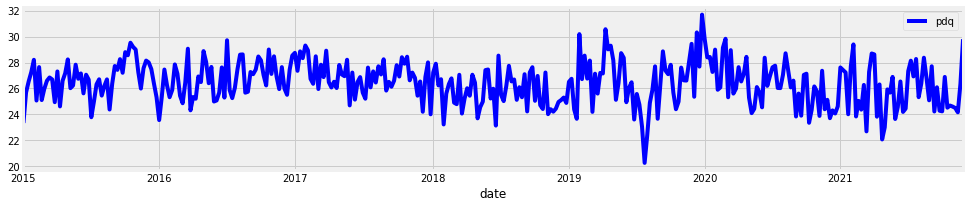

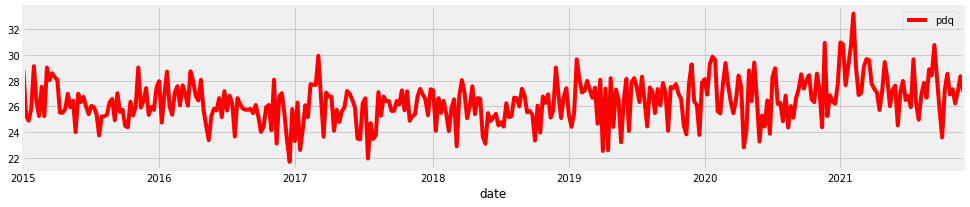

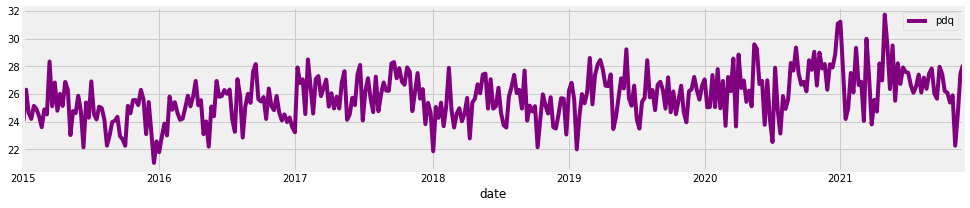

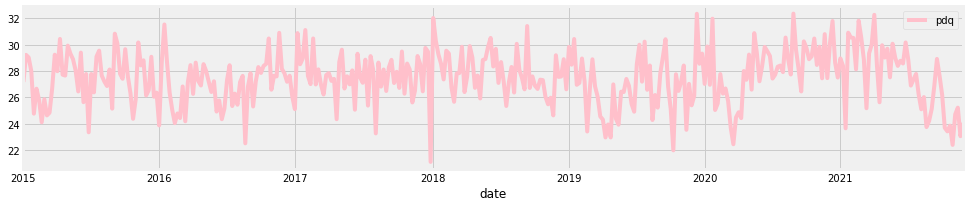

In [7]:
y_s1.plot(figsize=(15, 3),color = 'blue')
y_s2.plot(figsize=(15, 3),color = 'red')
y_s3.plot(figsize=(15, 3),color = 'purple')
y_s4.plot(figsize=(15, 3),color = 'pink')
plt.show()

2. Escoger alguna serie temporal $y\_{si}, i =1,2,3,4$. Luego:

* Realice un análisis exploratorio de la serie temporal escogida
* Aplicar el modelo de pronóstico $SARIMA(p,d,q)x(P,D,Q,S)$, probando varias configuraciones de los hiperparámetros. Encuentre la mejor configuración. Concluya.
* Para el mejor modelo encontrado, verificar si el residuo corresponde a un ruido blanco.

> **Hint**: Tome como `target_date` =  '2021-01-01'. Recuerde considerar que su columna de valores se llama `pdq`.


Se escoge y_s3

In [13]:
y_s3.isna()

,pdq
date,
2015-01-04,False
2015-01-11,False
2015-01-18,False
2015-01-25,False
2015-02-01,False
...,...
2021-10-31,False
2021-11-07,False
2021-11-14,False


In [17]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params
        
        
    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')
    
    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]        
        
        return y_train, y_test
    
    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)

        return model_fit
    
    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        
        model_fit = model.fit(disp=0)
        
        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )
        
        return df_temp
    
    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model
        
        return df_metrics

# definir parametros 

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

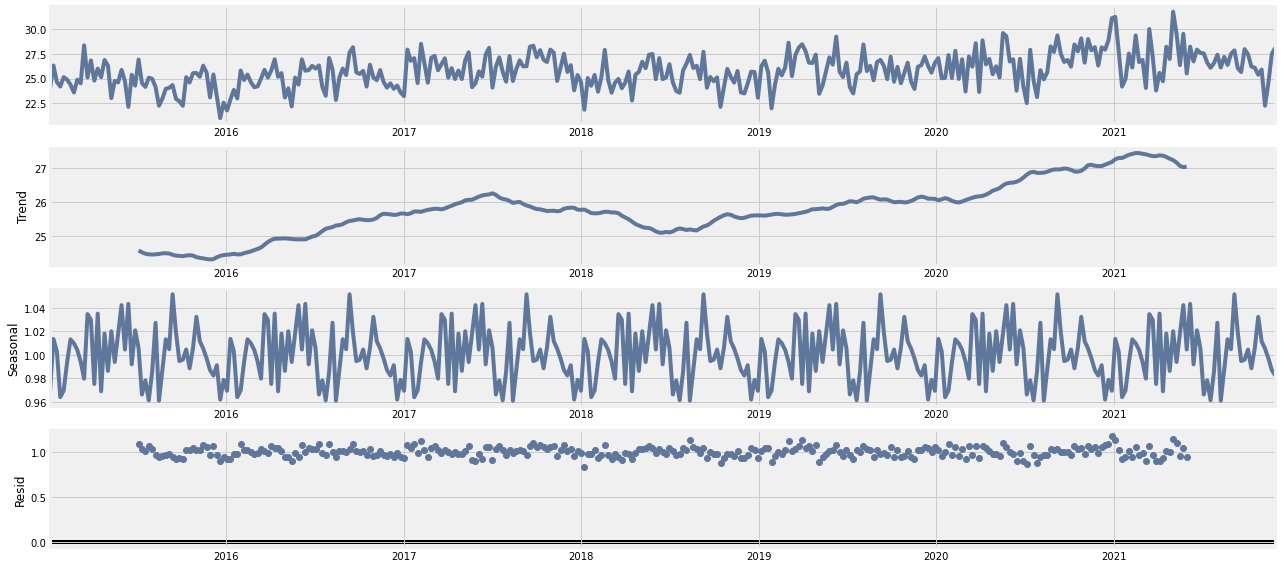

In [15]:
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_s3, model='multiplicative')
fig = decomposition.plot()
plt.show()

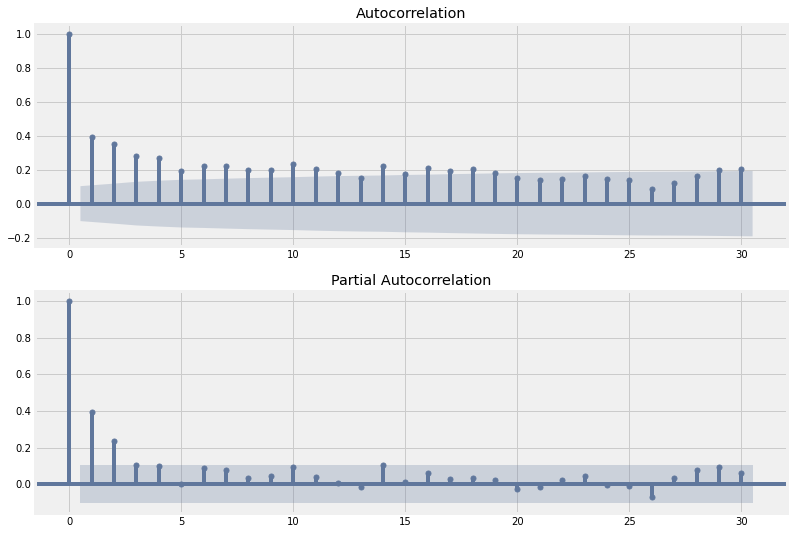

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize=(12,9))

# acf
pyplot.subplot(211)
plot_acf(y_s3.pdq, ax=pyplot.gca(), lags = 30)

#pacf
pyplot.subplot(212)
plot_pacf(y_s3.pdq, ax=pyplot.gca(), lags = 30)
pyplot.show()

In [11]:
# fix me please

In [18]:
from statsmodels.tsa.stattools import adfuller

print ('Resultados del test de Dickey-Fuller:')
dftest = adfuller(y_s3.pdq, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Resultados del test de Dickey-Fuller:
Test Statistic                -5.742935e+00
p-value                        6.215017e-07
#Lags Used                     3.000000e+00
Number of Observations Used    3.570000e+02
dtype: float64


In [19]:
frames = []
for param in params:
    try:
        sarima_model = SarimaModels(param)
        df_metrics = sarima_model.metrics(y_s3,target_date)
        frames.append(df_metrics)
    except:
        pass

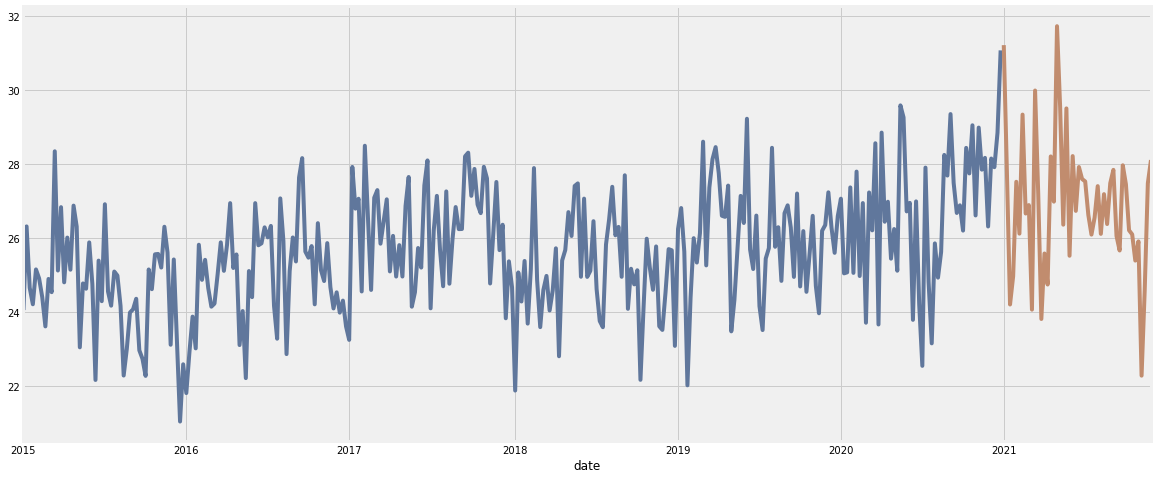

In [20]:
mask_ds = y_s3.index < target_date

y_train = y_s3[mask_ds]
y_test = y_s3[~mask_ds]


y_train['pdq'].plot()
y_test['pdq'].plot()
plt.show()

In [21]:
df_metrics_result = pd.concat(frames)
df_metrics_result.sort_values(['mae','mape'])

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.3633,3.4296,1.8519,0.0500,0.0499,0.0507,0.0482,0.0507,"SARIMA_(0,0,0)X(1,1,1,12)"
0,1.3657,3.1739,1.7815,0.0511,0.0509,0.0508,0.0492,0.0508,"SARIMA_(1,0,0)X(1,0,1,12)"
0,1.3671,3.3476,1.8296,0.0500,0.0499,0.0508,0.0483,0.0508,"SARIMA_(0,0,1)X(0,1,1,12)"
0,1.3671,3.3476,1.8297,0.0501,0.0499,0.0508,0.0483,0.0508,"SARIMA_(0,0,1)X(1,1,1,12)"
0,1.3695,3.4389,1.8544,0.0502,0.0500,0.0509,0.0484,0.0509,"SARIMA_(0,0,0)X(0,1,1,12)"
...,...,...,...,...,...,...,...,...,...
0,13.5654,221.9233,14.8971,0.5134,0.4559,0.5044,0.4946,0.3932,"SARIMA_(0,1,0)X(0,1,0,12)"
0,23.2099,586.6421,24.2207,0.8634,0.6930,0.8631,0.8323,1.6564,"SARIMA_(0,0,0)X(0,0,1,12)"
0,23.4758,587.2360,24.2330,0.8737,0.7040,0.8730,0.8422,1.6618,"SARIMA_(0,0,1)X(0,0,1,12)"
0,26.6276,713.2692,26.7071,0.9915,0.7802,0.9902,0.9558,1.9759,"SARIMA_(0,0,1)X(0,0,0,12)"


In [22]:
param = [(0,0,0),(1,0,1,12)]
sarima_model =  SarimaModels(param)
model_fit = sarima_model.fit_model(y_s3,target_date)
best_model = sarima_model.df_testig(y_s3,target_date)
best_model.head()

,y,yhat
2021-01-03,31.220000,26.400932
2021-01-10,27.801527,26.573434
2021-01-17,24.200000,26.650255
2021-01-24,24.966667,26.798880
2021-01-31,27.520833,26.756990


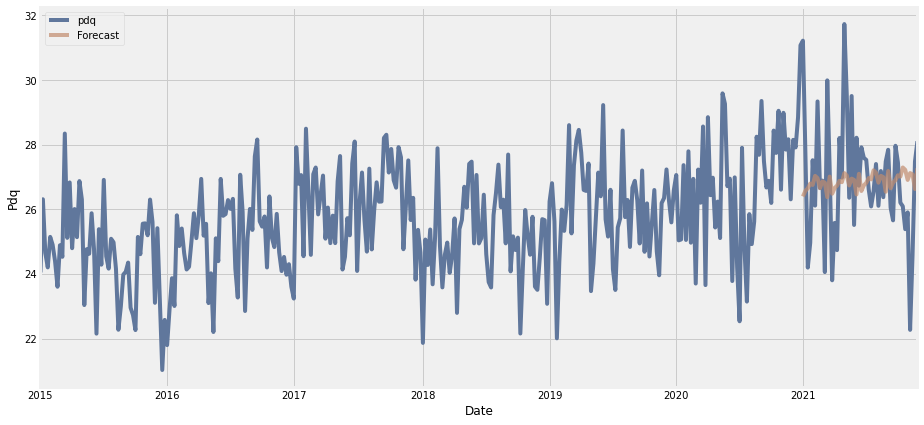

In [23]:
preds = best_model['yhat']
ax = y_s3.plot(label='observed')
preds.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Pdq')
plt.legend()
plt.show()

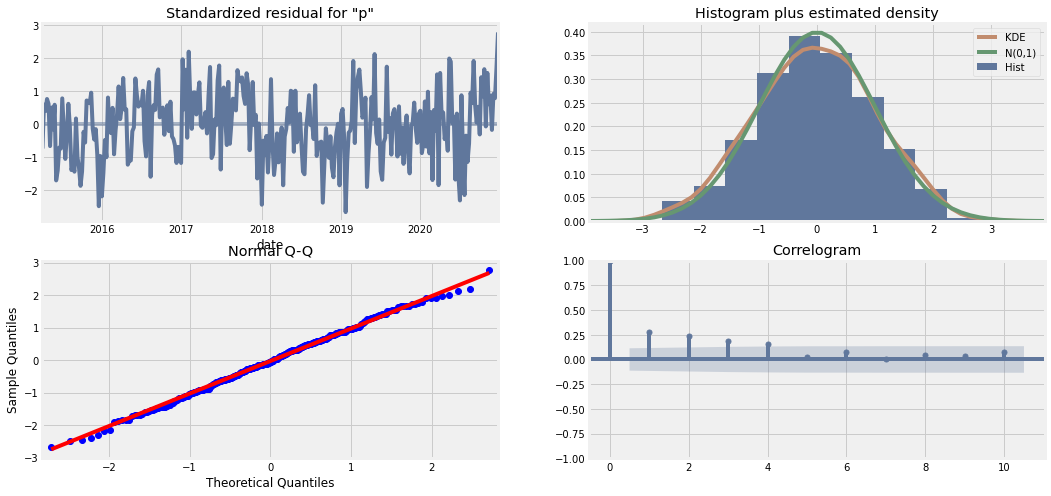

In [24]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

Dado que el residuo distribuye normal con media 0 y varianza 1, concluimos que el residuo es un ruido blanco.